In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os

from jamie import JAMIE
from jamie.evaluation import *
from jamie.utilities import *
import matplotlib.pyplot as plt
from mmd_wrapper import mmd_combine
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import preprocessing

2022-12-30 08:39:08.794342: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-30 08:39:08.886999: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-12-30 08:39:08.891169: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-30 08:39:08.891179: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
np.random.seed(42)
model_folder = './saved_models/'
image_folder = './output_figures/tuning-half/'
output_folder = './output_data/'

In [4]:
dataset_name = 'scMNC-Visual'
dataset_color = 'magenta'
modality_names = ['Gene Expression', 'Electrophysiology']
data_folder = '../data/scMNC/mouse_visual_cortex/data/'
data1 = pd.read_csv(data_folder + "geneExp_filtered.csv")
data2 = pd.read_csv(data_folder + "efeature_filtered.csv")
sample_names1 = data1.columns[1:]
sample_names2 = np.array(data2)[:, 0]
feature_names1 = data1.iloc[:,0]
feature_names2 = data2.columns[3:]
assert (sample_names1 == sample_names2).all()
data1 = np.transpose(np.array(data1)[:, 1:])
data2 = np.array(data2)[:, 3:]
meta = pd.read_csv(data_folder + "20200711_patchseq_metadata_mouse.csv")
meta_names = np.array(meta.columns)
meta_sid = np.argwhere(meta_names == 'transcriptomics_sample_id')[0][0]
meta_ttype = np.argwhere(meta_names == 't_type')[0][0]
meta = np.array(meta)
meta_idx = [np.argwhere(meta[:, meta_sid] == sample_names1[i])[0][0] for i in range(sample_names1.shape[0])]
type1 = type2 = np.array([x.split(' ')[0] for x in meta[meta_idx, meta_ttype]])

# Sampling
# split = 1000 # data1.shape[0]
# data_col_idx = np.random.choice(range(data1.shape[0]), split, replace=False)
# data1, data2, type1, type2 = (x[data_col_idx] for x in (data1, data2, type1, type2))

# Labels
labels = [type1, type2]
features = [np.array(feature_names1), np.array(feature_names2)]
feature_dict = {}

# Utility
positivize = lambda X: [x + x.min() for x in X]
minmax = lambda X: [(x + x.min()) for x in X]

In [5]:
# Preprocessing
data1 = preprocessing.scale(data1, axis=0)
data2 = preprocessing.scale(data2, axis=0)
data1[np.isnan(data1)] = 0  # Replace NaN with average
data2[np.isnan(data2)] = 0
# data1 = preprocessing.MinMaxScaler().fit_transform(data1)
# data2 = preprocessing.MinMaxScaler().fit_transform(data2)
dataset = [data1, data2]

# Replace NULL feature names
for i in range(len(features)):
    if features[i] is None:
        features[i] = np.array([f'Feature {i}' for i in range(dataset[i].shape[1])])
        
# Train-Test Imputation
train_size = int(.8 * len(data1))
train_idx = np.random.choice(range(len(data1)), train_size, replace=False)
test_idx = np.array(list(set(range(len(data1))) - set(train_idx)))

# Reduced Priors
full_priors = np.eye(len(dataset[0]))
random_idx = np.random.choice(range(len(dataset[0])), int(.5 * len(dataset[0])), replace=False)
priors = np.zeros(len(dataset[0]))
priors[random_idx] = 1
half_priors = np.diag(priors)
random_idx = np.random.choice(range(len(dataset[0])), int(.75 * len(dataset[0])), replace=False)
priors = np.zeros(len(dataset[0]))
priors[random_idx] = 1
tq_priors = np.diag(priors)
random_idx = np.random.choice(range(len(dataset[0])), int(.25 * len(dataset[0])), replace=False)
priors = np.zeros(len(dataset[0]))
priors[random_idx] = 1
q_priors = np.diag(priors)
none_priors = np.zeros((len(dataset[0]), len(dataset[0])))

In [6]:
reduced_dim = 32
kwargs = {
    'output_dim': reduced_dim,
    'epoch_DNN': 10000,
    'min_epochs': 2500,
    'log_DNN': 500,
    'use_early_stop': True,
    'batch_size': 512,
    'pca_dim': 2*[512],
    'dist_method': 'euclidean',
    'loss_weights': [1,1,1,1],
    'dropout': 0,
}
kwargs_imp = {k: kwargs[k] for k in kwargs if k != 'dropout'}

In [7]:
integrated_data = []
integrated_names = []
colors = []
shapes = []

# JAMIE

In [8]:
# Integration
size_str, hash_str = hash_kwargs(kwargs, dataset_name, dataset)
prefix = model_folder + 'jm_25---'
model_str = prefix + hash_str + '.h5'
match_str = prefix + size_str + '.npy'

# Instantiate
mr = list(np.load(match_str, allow_pickle=True)) if os.path.exists(match_str) else None
jm = JAMIE(**kwargs, match_result=mr, debug=True)

# Train
if os.path.exists(model_str):
    jm.load_model(model_str)
    print(f'Loaded model \'{model_str}\'')
else:
    jm_data = jm.fit_transform(dataset=dataset, P=q_priors)
    jm.save_model(model_str)
    np.save(match_str, jm.match_result, allow_pickle=True)
jm_data = jm.transform(dataset=dataset)
integrated_data.append(jm_data)
integrated_names.append('JAMIE')
colors.append('blue')
shapes.append('8')

use random seed: 666
Shape of Raw data
Dataset 0: (3654, 1302)
Dataset 1: (3654, 39)
Device: cpu
---------------------------------
Find correspondence between Dataset 1 and Dataset 2
epoch:[500/2000] err:0.4526 alpha:0.0207
epoch:[1000/2000] err:0.0000 alpha:0.0000


KeyboardInterrupt: 

In [ ]:
def run_jamie(kwargs, dataset, idx=None, prior=q_priors, hashName='jm_25---'):
    size_str, hash_str = hash_kwargs(kwargs, dataset_name, dataset)
    prefix = model_folder + hashName
    model_str = prefix + hash_str + '.h5'
    match_str = prefix + size_str + '.npy'

    # Instantiate
    mr = list(np.load(match_str, allow_pickle=True)) if os.path.exists(match_str) else None
    jm = JAMIE(**kwargs, match_result=mr, debug=True)

    # Train
    if os.path.exists(model_str):
        jm.load_model(model_str)
        print(f'Loaded model \'{model_str}\'')
    else:
        jm_data = jm.fit_transform(dataset=dataset if idx is None else [d[idx] for d in dataset], P=prior)
        jm.save_model(model_str)
        np.save(match_str, jm.match_result, allow_pickle=True)
    jm_data = jm.transform(dataset=dataset)
    
    return jm, jm_data

for i, (name, lw, cl) in enumerate(zip(
    ('$\\gamma=0$', '$\\beta=0$', '$\\alpha=0$', '$\\kappa=0$'),
    ([1,1,1,0],[1,1,0,1],[1,0,1,1],[0,1,1,1]),
    ('pink', 'orange', 'green', 'red'),)):
    if i != 0:
        continue
    print(f'{name}: {lw}')
    # result = run_jamie({k: kwargs[k] if k != 'loss_weights' else lw for k in kwargs}, half_priors, 'jm_50---')
    result = run_jamie({k: kwargs[k] if k != 'loss_weights' else lw for k in kwargs}, dataset)
    integrated_data.append(result[1])
    integrated_names.append(f'JAMIE ({name})')
    colors.append(cl)
    shapes.append('o')
    print()

In [10]:
# result = run_jamie({k: kwargs[k] if k != 'pca_dim' else 2*[128] for k in kwargs}, dataset)
# integrated_data.append(result[1])
# integrated_names.append('JAMIE (pca$=128$)')
# colors.append('yellow')
# shapes.append('s')

# result = run_jamie({k: kwargs[k] if k != 'pca_dim' else 2*[32] for k in kwargs}, dataset)
# integrated_data.append(result[1])
# integrated_names.append('JAMIE (pca$=32$)')
# colors.append('purple')
# shapes.append('s')

# result = run_jamie({k: kwargs[k] if k != 'output_dim' else 16 for k in kwargs}, dataset)
# integrated_data.append(result[1])
# integrated_names.append('JAMIE ($g=16$)')
# colors.append('teal')
# shapes.append('*')

# result = run_jamie({k: kwargs[k] if k != 'output_dim' else 8 for k in kwargs}, dataset)
# integrated_data.append(result[1])
# integrated_names.append('JAMIE ($g=8$)')
# colors.append('lime')
# shapes.append('*')

In [15]:
# Imputation
size_str, hash_str = hash_kwargs(kwargs_imp, dataset_name, dataset)
prefix = model_folder + 'jm_im_25---'
model_str = prefix + hash_str + '.h5'
match_str = prefix + size_str + '.npy'

# Instantiate
mr = list(np.load(match_str, allow_pickle=True)) if os.path.exists(match_str) else None
jm_im = JAMIE(**kwargs_imp, match_result=mr, debug=True)

# Train
if os.path.exists(model_str):
    jm_im.load_model(model_str)
    print(f'Loaded model \'{model_str}\'')
else:
    jm_im.fit_transform(dataset=[d[train_idx] for d in dataset], P=q_priors[train_idx, :][:, train_idx])
    jm_im.save_model(model_str)
    np.save(match_str, jm_im.match_result, allow_pickle=True)
jm_imputed = [jm_im.modal_predict(dataset[i], i) for i in range(1, -1, -1)]

use random seed: 666
Shape of Raw data
Dataset 0: (2923, 1302)
Dataset 1: (2923, 39)
---------------------------------
Train coupled autoencoders


/mnt/c/Users/nck/repos/nmacom/jamie/jamie.py:422: UserWarning: PCA dim must be lower than 39, found 512, adjusting to compensate.
  warnings.warn(


Epoch: 100 - KL: 0.0020  Rec: 1.4416  CosSim: 0.0983  F: 0.0031
Epoch: 200 - KL: 0.0030  Rec: 1.2969  CosSim: 0.0551  F: 0.0023
Epoch: 300 - KL: 0.0077  Rec: 1.2608  CosSim: 0.0456  F: 0.0024
Epoch: 400 - KL: 0.0137  Rec: 1.2102  CosSim: 0.0383  F: 0.0020
Epoch: 500 - KL: 0.0448  Rec: 1.3324  CosSim: 0.0336  F: 0.0018
epoch:[500/10000]: loss:1.320846
Epoch: 600 - KL: 0.0261  Rec: 1.1997  CosSim: 0.0274  F: 0.0015
Epoch: 700 - KL: 0.0471  Rec: 1.1538  CosSim: 0.0343  F: 0.0016
Epoch: 800 - KL: 0.0310  Rec: 1.1404  CosSim: 0.0308  F: 0.0015
Epoch: 900 - KL: 0.0720  Rec: 1.1481  CosSim: 0.0336  F: 0.0014
Epoch: 1000 - KL: 0.0694  Rec: 1.2650  CosSim: 0.0503  F: 0.0016
epoch:[1000/10000]: loss:1.294539
Epoch: 1100 - KL: 0.0825  Rec: 1.1344  CosSim: 0.0394  F: 0.0015
Epoch: 1200 - KL: 0.0880  Rec: 1.3181  CosSim: 0.0435  F: 0.0016
Epoch: 1300 - KL: 0.1130  Rec: 1.1473  CosSim: 0.0426  F: 0.0015
Epoch: 1400 - KL: 0.1097  Rec: 1.0955  CosSim: 0.0396  F: 0.0012
Epoch: 1500 - KL: 0.1867  Rec: 1

# Comparison Methods

In [16]:
# Imputation
if False:
    imputation_name = 'Babel'
else:
    imputation_name = 'KNN'
    nn_imputed = [predict_knn(torch.tensor(dataset[i][train_idx]).float(), torch.tensor(dataset[(i+1)%2][train_idx]).float(), torch.tensor(dataset[i]).float()) for i in range(1, -1, -1)]
imputed_data_full = [jm_imputed, nn_imputed][::-1]
imputed_data = [[d[test_idx] for d in ds] for ds in imputed_data_full]
imputed_names = ['JAMIE (.5)', imputation_name][::-1]

# Visualization

In [ ]:
style='white'
sns.set(style=style)
plt.rcParams.update({'font.weight': 'normal',
                     'font.size': 18,
                     'axes.titlesize': 'large',
                     'axes.labelsize': 'large',
                     'xtick.labelsize': 'small',
                     'ytick.labelsize': 'small'})

In [ ]:
%%capture
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

algorithm_elements = [Line2D([0], [0], marker='s', color='w', markerfacecolor=c, label=n, markersize=10) for n, c in zip(integrated_names, colors)]
label_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=plt.rcParams['axes.prop_cycle'].by_key()['color'][i], label=l, markersize=10) for i, l in enumerate(np.unique(labels))]

# https://stackoverflow.com/a/47749903
fig, ax = plt.subplots()
legend = ax.legend(handles=label_elements, loc='center', frameon=False, ncol=min(len(label_elements), 4))
legend.figure.canvas.draw()
bbox = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
plt.axis('off')
plt.savefig(image_folder + dataset_name + '-LabelLegend.png', bbox_inches=bbox, dpi=300)

fig, ax = plt.subplots()
legend = ax.legend(handles=algorithm_elements, loc='center', frameon=False)
legend.figure.canvas.draw()
bbox = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
plt.axis('off')
plt.savefig(image_folder + dataset_name + '-AlgorithmLegend.png', bbox_inches=bbox, dpi=300)

In [ ]:
from IPython.display import display, Image
display( Image(filename=image_folder + dataset_name + '-LabelLegend.png', width=400) )
display( Image(filename=image_folder + dataset_name + '-AlgorithmLegend.png', width=100) )

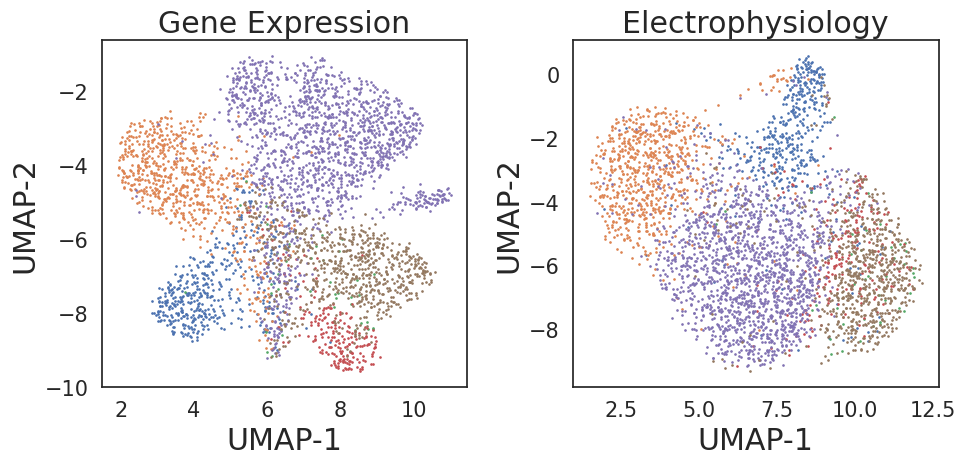

In [20]:
fig = plt.figure(figsize=(10, 5))
plot_regular(dataset, labels, modality_names)
plt.tight_layout()
plt.savefig(image_folder + dataset_name + '-Data.png', dpi=300, bbox_inches='tight')

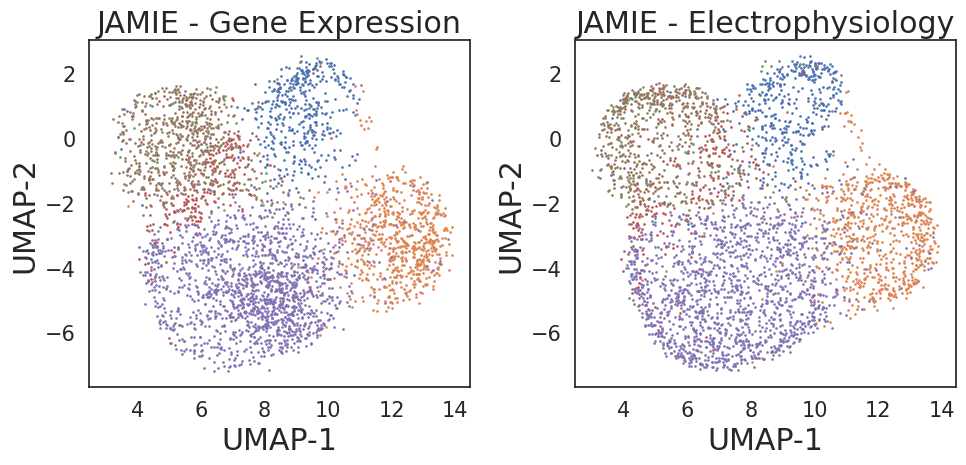

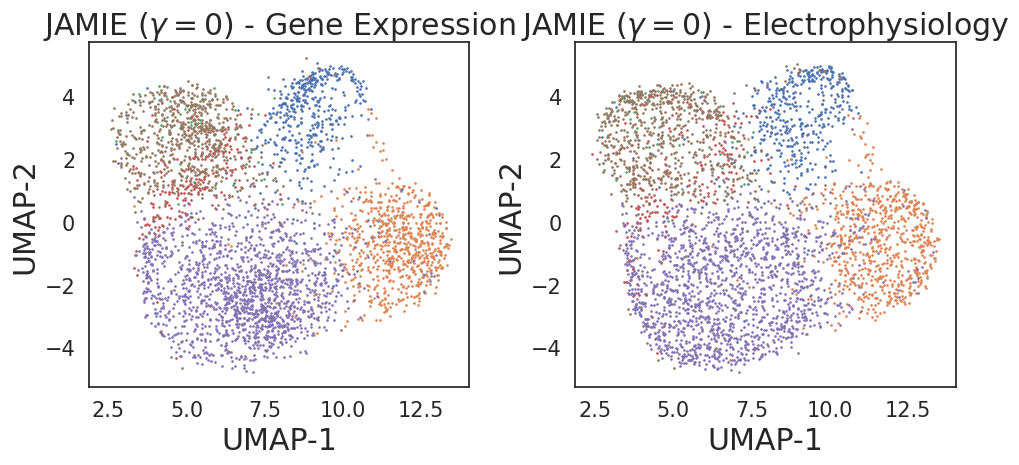

In [21]:
for d, n in zip(integrated_data, integrated_names):
    fig = plt.figure(figsize=(10, 5))
    plot_integrated(d, labels, [f'{n} - ' + mn for mn in modality_names])
    plt.tight_layout()
    plt.savefig(image_folder + dataset_name + f'-{n}.png', dpi=300, bbox_inches='tight')
    plt.show()

In [ ]:
plt.figure(figsize=(5, 5))
plot_accuracy_graph(integrated_data, labels, integrated_names, colors=colors, shapes=shapes)
plt.savefig(image_folder + dataset_name + '-AccWeight.png', dpi=300, bbox_inches='tight')

In [23]:
# plt.figure(figsize=(15, 5))
# plot_silhouette([[d[0]] for d in integrated_data], [labels[0]], integrated_names, modality_names[:1], colors=colors)
# sns.despine()
# plt.tight_layout()
# plt.savefig(image_folder + dataset_name + '-Sil.png', dpi=300, bbox_inches='tight')

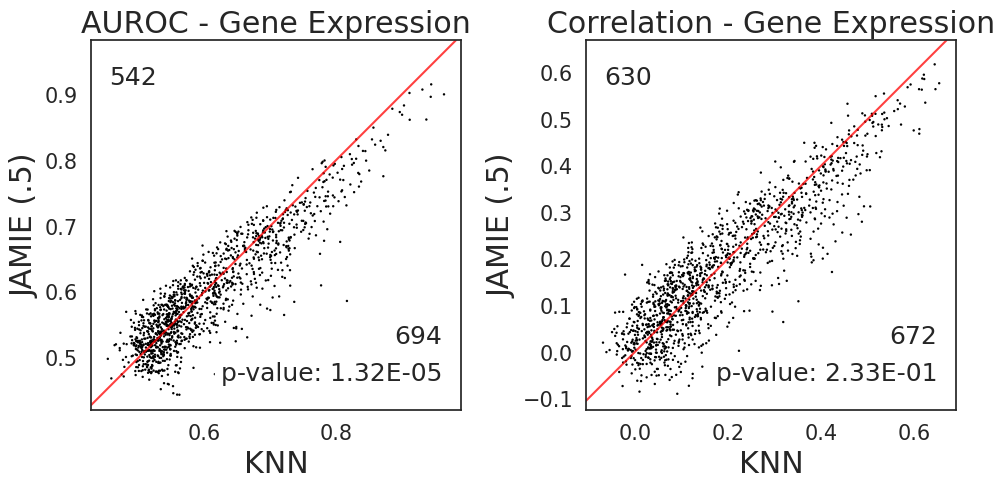

In [24]:
plt.figure(figsize=(10, 5))
plot_auroc_correlation(imputed_data, [data1[test_idx], data2[test_idx]], modality_names, index=0, names=imputed_names)
plt.tight_layout()
plt.savefig(image_folder + dataset_name + '-Imp1.png', dpi=300, bbox_inches='tight')

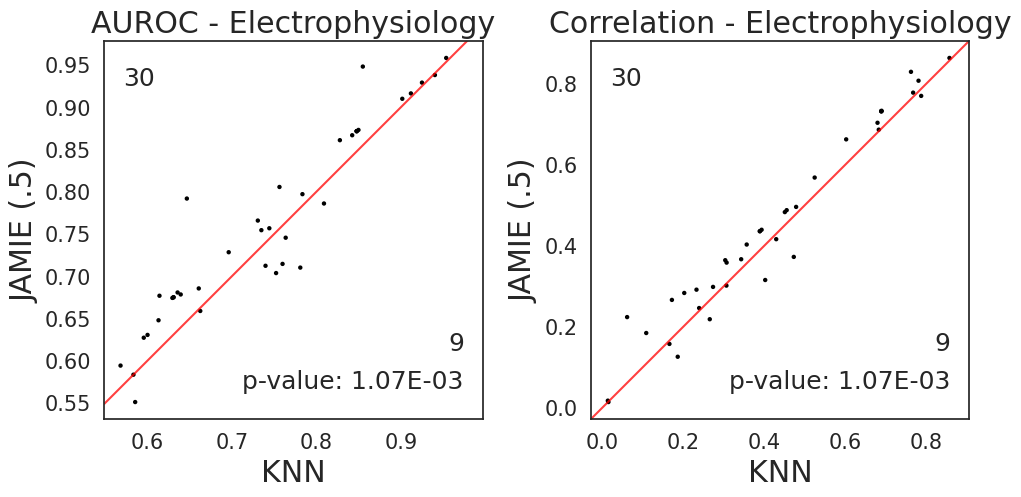

In [25]:
plt.figure(figsize=(10, 5))
plot_auroc_correlation(imputed_data, [data1[test_idx], data2[test_idx]], modality_names, index=1, names=imputed_names)
plt.tight_layout()
plt.savefig(image_folder + dataset_name + '-Imp2.png', dpi=300, bbox_inches='tight')

Dock4: 0.4816346323592675
Kcnc1: 0.4409815507255921


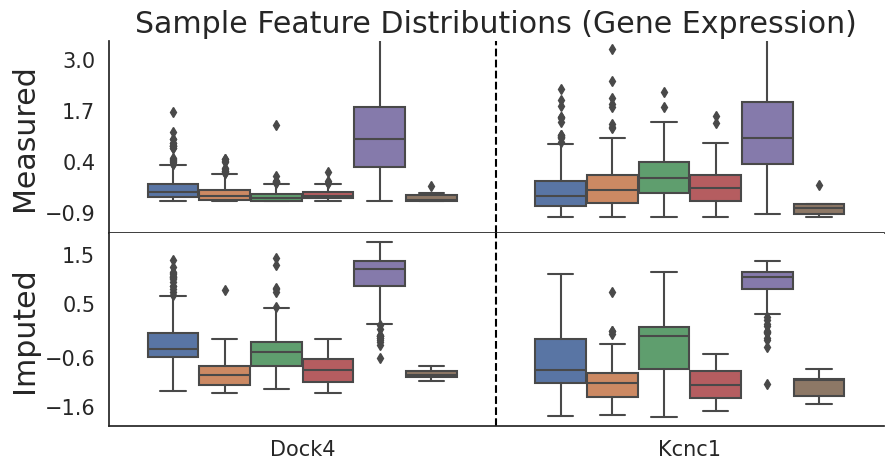

In [26]:
plt.figure(figsize=(10, 5))
plot_distribution_alone([dataset[0][test_idx], jm_imputed[0][test_idx]], 2*[labels[0][test_idx]], title=modality_names[0], fnames=2*[features[0]], feature_dict=feature_dict)
sns.despine()
plt.savefig(image_folder + dataset_name + '-Dist1.png', dpi=300, bbox_inches='tight')

threshold_i_ramp: 0.30818412247320803
threshold_t_ramp: 0.3138120885028973


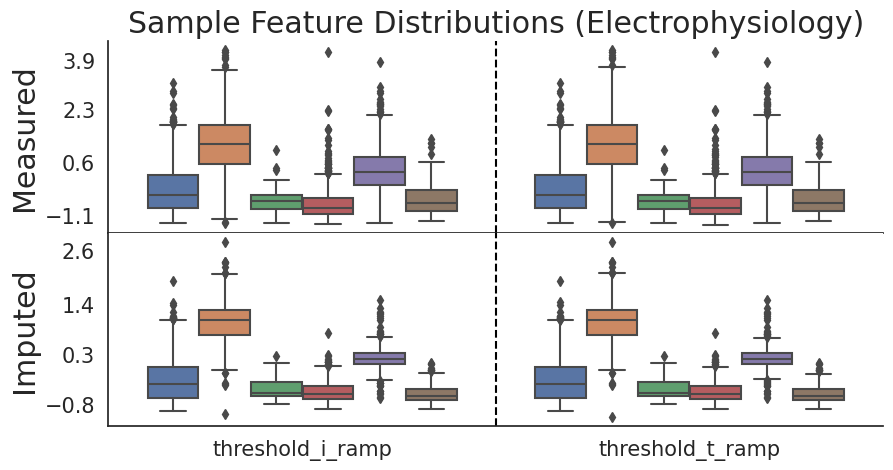

In [27]:
plt.figure(figsize=(10, 5))
plot_distribution_alone([dataset[1], jm_imputed[1]], 2*[labels[1]], title=modality_names[1], fnames=2*[features[1]], feature_dict=feature_dict, remove_outliers=False)
sns.despine()
plt.savefig(image_folder + dataset_name + '-Dist2.png', dpi=300, bbox_inches='tight')

Mean: 0.5758992194457325
Std: 0.12009136035877335


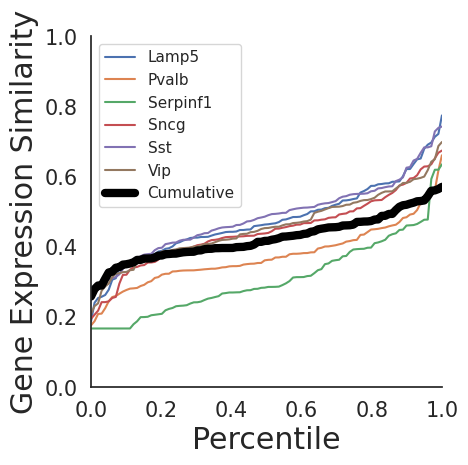

In [28]:
plt.figure(figsize=(5, 5))
plot_distribution_similarity([dataset[0][test_idx], jm_imputed[0][test_idx]], 2*[labels[0][test_idx]], title=modality_names[0], fnames=2*[features[0]])
sns.despine()
plt.tight_layout()
plt.savefig(image_folder + dataset_name + '-Sim1.png', dpi=300, bbox_inches='tight')

Mean: 0.5474199304225631
Std: 0.12041848836409468


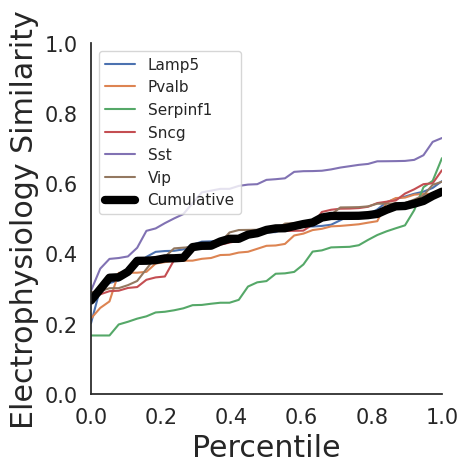

In [29]:
plt.figure(figsize=(5, 5))
plot_distribution_similarity([dataset[1][test_idx], jm_imputed[1][test_idx]], 2*[labels[1][test_idx]], title=modality_names[1], fnames=2*[features[1]])
sns.despine()
plt.tight_layout()
plt.savefig(image_folder + dataset_name + '-Sim2.png', dpi=300, bbox_inches='tight')